#  CNN개념이해_MNIST

* 본 파일은 GPU 런타임으로 연결됩니다.
* 경우에 따라서는 GPU 연결이 원할하지 않을 수도 있습니다.

## 1.환경준비

### (1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
import cv2, os

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist, fashion_mnist

In [2]:
!pip install opencv-python

* 함수 만들기

In [3]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err')
    plt.plot(history['val_loss'], label='val_err')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (2) 데이터로딩

![](https://wikidocs.net/images/page/60324/mnist.png)

In [4]:
# 케라스 데이터셋으로 부터 mnist 불러오기
(x_train, y_train), (x_val, y_val) = mnist.load_data()

In [5]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

* 이미지 : 행 * 열 * 칼라(3)/흑백(1) 
* mnist 이미지 1장의 shape : 28 * 28 * 1 
* 칼라(3) : 빛의 3원색 - red, green, blue

In [6]:
class_names = ['0','1','2','3','4','5','6','7','8','9']

## 2 데이터 살펴보기
* 아래 코드는 실행해보는 용도로만 사용합니다.
* 자세한 문법 설명을 하지 않습니다.

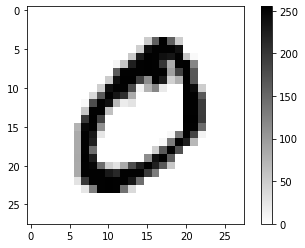

In [7]:
# 아래 숫자를 바꿔가며 화면에 이미지를 출력해 봅시다.
n = 1

plt.figure()
plt.imshow(x_train[n], cmap=plt.cm.binary)
plt.colorbar()
plt.show()

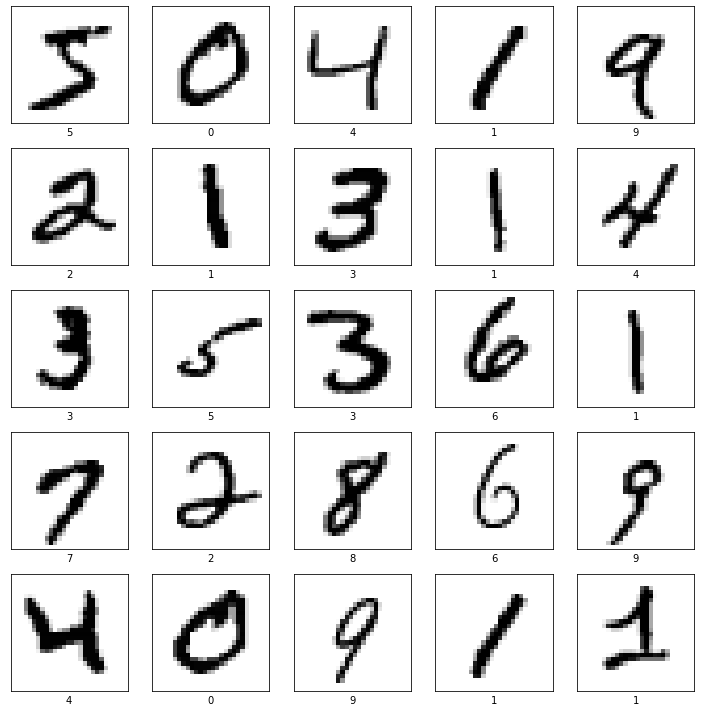

In [8]:
# 이미지 25장을 한꺼번에 그려 봅시다.
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.tight_layout()
plt.show()

## 3.데이터 준비

* CNN은 3차원 구조의 이미지(데이터셋은 4차원)를 입력해야 합니다.(input_shape)

In [9]:
x_train.shape, x_val.shape

((60000, 28, 28), (10000, 28, 28))

In [18]:
x_train

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

* reshape를 이용하여 다음과 같이 변환해 봅시다.
    * x_train.shape : (60000, 28, 28, 1)
    * x_val.shape : (10000, 28, 28, 1) 

In [12]:
x_train = x_train.reshape(60000,28,28,1)
x_val = x_val.reshape(10000,28,28,1)

* Scaling : Min-Max
    * 0-255 값으로 되어 있는 데이터를 0-1사이 값으로 변환
    * x_train, x_test를 그냥 255로 나누면 됨

In [13]:
x_train = x_train / 255.
x_val = x_val / 255.

## 5.CNN 기본 모델링

### (1) 모델 설계
* CNN 모델의 기본 구조
    * Conv2D  : 지역적인 특징 도출
    * MaxPooling : 요약(데이터 사이즈 줄이기)
    * Flatten : 1차원으로 펼치기
    * Dense : Output Layer

In [19]:
clear_session()

model = Sequential([Conv2D(16, kernel_size=(3, 3), input_shape=(28, 28, 1), padding='same', strides = (1,1), activation='relu'),
                    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),    # maxpooling은 요약만을 수행하므로 activation 없음. 
                    Flatten(),
                    Dense(10, activation='softmax')
])

model.summary()

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 10)                31370     
                                                                 
Total params: 31,530
Trainable params: 31,530
Non-trainable params: 0
_________________________________________________________________


### (2) 학습

In [20]:
history = model.fit(x_train, y_train, epochs = 10, validation_split=0.2).history

Epoch 1/10
1500/1500 [==============================] - 17s 10ms/step - loss: 1.1650 - val_loss: 0.2317
Epoch 2/10
1500/1500 [==============================] - 15s 10ms/step - loss: 0.1279 - val_loss: 0.1567
Epoch 3/10
1500/1500 [==============================] - 16s 11ms/step - loss: 0.0850 - val_loss: 0.1365
Epoch 4/10
1500/1500 [==============================] - 15s 10ms/step - loss: 0.0732 - val_loss: 0.1386
Epoch 5/10
1500/1500 [==============================] - 15s 10ms/step - loss: 0.0654 - val_loss: 0.1514
Epoch 6/10
1500/1500 [==============================] - 15s 10ms/step - loss: 0.0570 - val_loss: 0.1392
Epoch 7/10
1500/1500 [==============================] - 16s 11ms/step - loss: 0.0563 - val_loss: 0.1348
Epoch 8/10
1500/1500 [==============================] - 20s 13ms/step - loss: 0.0478 - val_loss: 0.1552
Epoch 9/10
1500/1500 [==============================] - 18s 12ms/step - loss: 0.0433 - val_loss: 0.1705
Epoch 10/10
1500/1500 [==============================] - 15s 10m

### (3) 학습결과 그래프

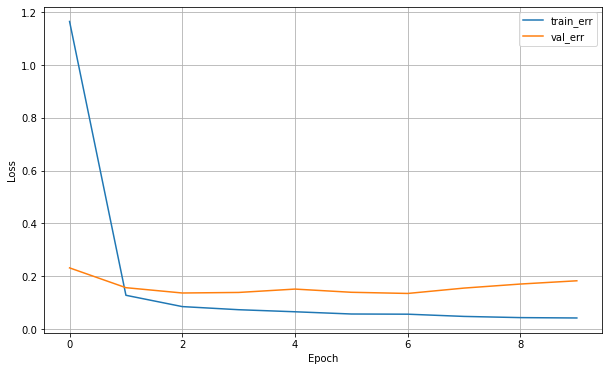

In [21]:
dl_history_plot(history)

### (4) 예측 및 평가

In [22]:
pred = model.predict(x_val)

313/313 [==============================] - 2s 6ms/step


In [23]:
pred_1 = pred.argmax(axis=1)

In [24]:
print(accuracy_score(y_val,pred_1))
print('-'*60)
print(confusion_matrix(y_val, pred_1))
print('-'*60)
print(classification_report(y_val, pred_1))

0.9729
------------------------------------------------------------
[[ 967    0    2    0    0    0    5    2    4    0]
 [   0 1128    4    0    1    0    2    0    0    0]
 [   2    2 1001    7    1    0    1   12    5    1]
 [   0    0    2  997    0    5    0    1    1    4]
 [   1    1    1    0  938    1    6    3    2   29]
 [   1    1    0   14    0  859    7    1    2    7]
 [   2    2    0    0    3    5  945    0    1    0]
 [   0    3   12    5    1    2    0  997    0    8]
 [   4    1    7    5    3    9    3    4  915   23]
 [   1    5    0    4    6    3    0    6    2  982]]
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.97      0.99      0.98      1010
           4       0.98      0.96      0.97       982
           5   

## 6.실습


### (1) 모델1
* 기본 모델링을 복사해서 붙여 넣고 다음을 조정해 봅시다.
    * Flatten 이후 Dense 레이어 추가(노드수 128)

| Layer (type) | Output Shape  | Param #   |
|---- |----|----|
| conv2d (Conv2D)  |  (None, 28, 28, 16) | 160       |
| max_pooling2d |  (None, 14, 14, 16) |      0         |
| flatten (Flatten) | (None, 3136)   |           0         |
| **dense (Dense)** |    **(None, 128)**   |            401536    |
| dense_1 (Dense) |    (None, 10)   |             1290     |

* 모델 구조

In [34]:
# clear_session()

model2 = Sequential([Conv2D(16, kernel_size=(3, 3), input_shape=(28, 28, 1), padding='same', strides = (1,1), activation='relu'),
                    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),    # maxpooling은 요약만을 수행하므로 activation 없음. 
                    Flatten(),
                    Dense(128, activation='relu'),
                    Dense(10, activation='softmax')
])

model2.summary()

model2.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               401536    
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 402,986
Trainable params: 402,986
Non-trainable params: 0
________________________________________________

* 컴파일 및 학습

In [35]:
model2.compile(optimizer=Adam(lr=0.001),loss='sparse_categorical_crossentropy')

C:\Users\User\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


* 학습결과 그래프

In [36]:
history2 = model.fit(x_train, y_train, epochs=10, validation_split=0.2).history

Epoch 1/10
1500/1500 [==============================] - 20s 13ms/step - loss: 0.0208 - val_loss: 0.1353
Epoch 2/10
1500/1500 [==============================] - 20s 13ms/step - loss: 0.0166 - val_loss: 0.1443
Epoch 3/10
1500/1500 [==============================] - 20s 13ms/step - loss: 0.0177 - val_loss: 0.1798
Epoch 4/10
1500/1500 [==============================] - 22s 14ms/step - loss: 0.0154 - val_loss: 0.1754
Epoch 5/10
1500/1500 [==============================] - 20s 13ms/step - loss: 0.0155 - val_loss: 0.1706
Epoch 6/10
1500/1500 [==============================] - 20s 14ms/step - loss: 0.0180 - val_loss: 0.2235
Epoch 7/10
1500/1500 [==============================] - 20s 14ms/step - loss: 0.0104 - val_loss: 0.1756
Epoch 8/10
1500/1500 [==============================] - 21s 14ms/step - loss: 0.0155 - val_loss: 0.1803
Epoch 9/10
1500/1500 [==============================] - 20s 13ms/step - loss: 0.0154 - val_loss: 0.2133
Epoch 10/10
1500/1500 [==============================] - 21s 14m

* 예측 및 평가

In [38]:
# 예측하기
pred = model2.predict(x_val)

313/313 [==============================] - 2s 5ms/step


In [39]:
# 예측결과 중 가장 확률이 높은 값 뽑기(argmax)
pred = np.argmax(pred, axis=1)

In [40]:
# 평가하기 (결과 잘못나옴. 다시돌려라 )
print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))

[[  0   0  83  12   0   0   0 841  17  27]
 [ 15   0 565   4 504   2   0  44   1   0]
 [  6   0 237  51  41  11   5 464 174  43]
 [  0   0 719  37   8   1   3 230  12   0]
 [  3   0 203 154   9   0   5 589  19   0]
 [  0   0 508  27   1   0   1 323  30   2]
 [  2   0 241   5  18   0   1 671   3  17]
 [  1   0 305  67   3   1   0 527 124   0]
 [  3   0 398  53   5   0   1 506   8   0]
 [  0   0 238  62   1   0   1 695  12   0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.00      0.00      0.00      1135
           2       0.07      0.23      0.10      1032
           3       0.08      0.04      0.05      1010
           4       0.02      0.01      0.01       982
           5       0.00      0.00      0.00       892
           6       0.06      0.00      0.00       958
           7       0.11      0.51      0.18      1028
           8       0.02      0.01      0.01       974
           9       0.00     

C:\Users\User\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### (2) 모델2
* 모델1의 결과를 복사해서 붙여 놓고, 다음을 조정해 봅시다.
    * Conv2d의 커널 수를 32로 늘려 봅시다.

| Layer (type) | Output Shape  | Param #   |
|---- |----|----|
| conv2d (Conv2D)  |  (None, 28, 28, **32**) | 320       |
| max_pooling2d |  (None, 14, 14, 32) |      0         |
| flatten (Flatten) | (None, 3136)   |           0         |
| dense (Dense) |    (None, 128)   |            802944        |
| dense_1 (Dense) |    (None, 10)   |             1290     |

* 모델 구조

In [41]:
clear_session()

In [42]:
model3 = Sequential([Conv2D(32, kernel_size=(3, 3), input_shape=(28, 28, 1), padding='same', strides = (1,1), activation='relu'),
                    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),    # maxpooling은 요약만을 수행하므로 activation 없음. 
                    Flatten(),
                    Dense(128, activation='relu'),
                    Dense(10, activation='softmax')
])

model3.summary()

model3.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 128)               802944    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 804,554
Trainable params: 804,554
Non-trainable params: 0
__________________________________________________

* 컴파일 및 학습

In [43]:
model3.compile(optimizer=Adam(lr=0.001),loss='sparse_categorical_crossentropy')

C:\Users\User\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [45]:
history3 = model3.fit(x_train, y_train, epochs=10, validation_split=0.2).history

Epoch 1/10
1500/1500 [==============================] - 25s 16ms/step - loss: 0.6103 - val_loss: 0.1235
Epoch 2/10
1500/1500 [==============================] - 23s 15ms/step - loss: 0.0939 - val_loss: 0.0889
Epoch 3/10
1500/1500 [==============================] - 24s 16ms/step - loss: 0.0608 - val_loss: 0.1040
Epoch 4/10
1500/1500 [==============================] - 24s 16ms/step - loss: 0.0492 - val_loss: 0.0923
Epoch 5/10
1500/1500 [==============================] - 23s 15ms/step - loss: 0.0380 - val_loss: 0.0965
Epoch 6/10
1500/1500 [==============================] - 24s 16ms/step - loss: 0.0336 - val_loss: 0.1013
Epoch 7/10
1500/1500 [==============================] - 24s 16ms/step - loss: 0.0271 - val_loss: 0.1082
Epoch 8/10
1500/1500 [==============================] - 24s 16ms/step - loss: 0.0228 - val_loss: 0.1275
Epoch 9/10
1500/1500 [==============================] - 24s 16ms/step - loss: 0.0196 - val_loss: 0.1322
Epoch 10/10
1500/1500 [==============================] - 23s 15m

* 학습결과 그래프

In [46]:
# 예측하기
pred = model3.predict(x_val)

313/313 [==============================] - 2s 7ms/step


* 예측 및 평가

In [47]:
# 예측결과 중 가장 확률이 높은 값 뽑기(argmax)
# 예측결과 중 가장 확률이 높은 값 뽑기(argmax)
pred = np.argmax(pred, axis=1)

In [48]:
# 평가하기
print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))

[[ 967    1    2    1    0    1    3    1    4    0]
 [   0 1117    4    2    0    0    0    3    5    4]
 [   3    1 1013    2    2    0    1    8    2    0]
 [   0    0    0  999    0    6    0    2    1    2]
 [   0    1    0    0  966    0    3    2    4    6]
 [   2    0    0    4    0  882    2    0    0    2]
 [   6    3    0    0    5    7  937    0    0    0]
 [   0    3    9    3    5    1    0 1002    2    3]
 [   2    1    0    5    0    9    2    2  945    8]
 [   6    3    2    6   13    5    0   14    3  957]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.98      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.97      0.98      0.98       982
           5       0.97      0.99      0.98       892
           6       0.99      0.98      0.98       958
           7       0.97      0.97   

### (3) 모델3
* 모델2를 복사해서 붙여 넣고, 
* 아래 그림을 보고 빠진 부분을 추가하시오.

![](https://github.com/DA4BAM/image/blob/main/cnn_mnist3.png?raw=true)

In [2]:
clear_session()

NameError: name 'clear_session' is not defined

* 모델 구조

In [50]:
model4 = Sequential([Conv2D(32, kernel_size=(3, 3), input_shape=(28, 28, 1), padding='same', strides = (1,1), activation='relu'),
                    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),    # maxpooling은 요약만을 수행하므로 activation 없음. 
                    Conv2D(64, kernel_size=(3, 3), padding='same', strides = (1,1), activation='relu'),
                    Flatten(),
                    Dense(128, activation='relu'),
                    Dense(10, activation='softmax')
])

model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 128)               1605760   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                        

* 컴파일 및 학습

In [51]:
model4.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')
history4 = model4.fit(x_train, y_train, epochs=10, validation_split=0.2).history

Epoch 1/10
1500/1500 [==============================] - 61s 40ms/step - loss: 0.2944 - val_loss: 0.1067
Epoch 2/10
1500/1500 [==============================] - 56s 38ms/step - loss: 0.0593 - val_loss: 0.0684
Epoch 3/10
1500/1500 [==============================] - 68s 45ms/step - loss: 0.0415 - val_loss: 0.0641
Epoch 4/10
1500/1500 [==============================] - 55s 37ms/step - loss: 0.0331 - val_loss: 0.0939
Epoch 5/10
1500/1500 [==============================] - 49s 33ms/step - loss: 0.0295 - val_loss: 0.0870
Epoch 6/10
1500/1500 [==============================] - 56s 38ms/step - loss: 0.0253 - val_loss: 0.0759
Epoch 7/10
1500/1500 [==============================] - 64s 42ms/step - loss: 0.0241 - val_loss: 0.0903
Epoch 8/10
1500/1500 [==============================] - 58s 39ms/step - loss: 0.0219 - val_loss: 0.1418
Epoch 9/10
1500/1500 [==============================] - 57s 38ms/step - loss: 0.0216 - val_loss: 0.0979
Epoch 10/10
1500/1500 [==============================] - 65s 43m

* 학습결과 그래프

* 예측 및 평가

In [1]:
# 예측하기
pred = model4.predict(x_val)

NameError: name 'model4' is not defined

In [ ]:
# 예측결과 중 가장 확률이 높은 값 뽑기(argmax)
pred = np.argmax(pred, axis=1)

In [ ]:
# 평가하기
print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))

## 7.틀린그림 찾아보기
* 모델3의 결과에서 틀린 그림을 살펴 봅시다.
* 아래코드는 이해하기보다는 그냥 사용하기 바랍니다.

In [ ]:
idx = (y_val != pred_1)
x_val_wr = x_val[idx]
y_val_wr = y_val[idx]
pred_wr = pred_1[idx]

x_val_wr = x_val_wr.reshape(-1,28,28)
print(x_val_wr.shape)

In [ ]:
idx = rd.sample(range(x_val_wr.shape[0]),25)
x_temp = x_val_wr[idx]
y_temp = y_val_wr[idx]
p_temp = pred_wr[idx]

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_temp[i], cmap=plt.cm.binary)
    plt.xlabel(f'actual : {y_temp[i]},  predict : {p_temp[i]}')
plt.tight_layout()
plt.show()

## 8.모델 저장하기

### (1) 모델 저장하기

In [ ]:
model.save('mnist_model.h5')

### (2) 모델 로딩하기

In [ ]:
from keras.models import load_model
model2 = load_model('mnist_model.h5')

* 불러온 모델 사용하기

In [ ]:
pred = model2.predict(x_val)

In [ ]:
pred_1 = pred.argmax(axis=1)

In [ ]:
print(accuracy_score(y_val,pred_1))
print('-'*60)
print(confusion_matrix(y_val, pred_1))
print('-'*60)
print(classification_report(y_val, pred_1))

## 9.진짜 손글씨로 예측해 봅시다.
* 새로운 데이터로 예측을 해보겠습니다.
    * 1) 필요한 라이브러리 불러오기
    * 2) 그림판에서 손글씨로 숫자 쓰기
    * 3) 손글씨 그림 불러오기
    * 4) 전처리 : 크기 맞추기(28,28,1)
    * 5) 모델로 예측해보기

* 이미지 처리를 위한 라이브러리와 함수 불러오기

In [14]:
import cv2
import cv2.imshow

SyntaxError: invalid syntax (<ipython-input-14-bb6fc66b1cc9>, line 2)

* 그림판에서 그린 손글씨를 업로드 합니다.
    * 왼쪽 파일 탭을 누르고 그림파일을 드래그 & 드롭 합니다.

In [16]:
# 파일 열기
filename = '5.png'
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)  # cv2.IMREAD_GRAYSCALE 이미지 읽을 때, 흑백으로 변환하기
cv2.imshow(filename,img) # 이미지를 화면에 보여주기 ???
print(img.shape)

(364, 371)


* 이미지 크기를 28, 28, 1 로 맞추기

In [ ]:
# 크기 조절하기
img = cv2.resize(255-img, (28, 28))    # mnist 데이터는 겉이 검정 글자가 흰색이므로 바꿔줌 
print(img.shape)
cv2_imshow(img)

* 예측하기

In [ ]:
# 입력데이터 형식을 갖추기
test_num = img.reshape(1,28,28,1)

# 예측하기
pred = model.predict(test_num)
pred_1 = pred.argmax(axis=1)
print(pred_1)